# Deep Neural Networks Exercise
 >__Created__:  2018 Harrison B. Prosper
  

### Neural Networks
A neural network is a highly non-linear function. The functional form of a single layer fully connected
network with $I$ inputs and $J$ outputs is

$$y_{j}(x) = f\left(b_{j} + \sum_{i=1}^I w_{ji} \, x_i\right),\quad j = 1,\cdots,J,$$
which in matrix notation is
$$\mathbf{y} = f\left(\mathbf{b} + \mathbf{w} \, \mathbf{x}\right),$$
where $f(*)$ is a non-linear function to be applied element-wise to its matrix argument. Popular examples of $f(*)$ are
\begin{align*}
    f(z) & = \tanh{z},\\
    f(z) & = \max(0, z) \quad\textrm{reLU function}.
\end{align*}

Consider a neural network with $I$ inputs, $x_{i}, i = 1, \cdots, I$, a single hidden layer with $H$ nodes, and $K$ outputs $y_{k}(x), k = 1, \cdots, K$. Such a network is said to be *shallow* with structure $(I, H, K)$. The functional form is

$$y = f^\prime(\mathbf{b}_1 + \mathbf{w}_1 \, f(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x})),$$

where the subscripts label the layers, and, usually, the output function $f^\prime$ differs from $f$. For regression,  $f^\prime$ is
the $identity$. For 2-class (i.e., binary) classification it is usually the $logistic$ function 

$$f^\prime(z) = \frac{1}{1 + \exp(-z)},$$ 

while for multi-class classification one typically uses the $softwmax$ function

$$y_j = f^\prime(z_j) = \frac{\exp(z_j)}{\sum_{k=1}^K \exp(z_k)}.$$ 

For the special case of a single output network, the $\mathbf{b}_1$ becomes a scalar $b$ and $\mathbf{w}_1$ 
is a column matrix.

### Deep Neural Networks
A feed forward deep neural network (DNN) contains two or more hidden layers 
compounded recursively. For example, a DNN with two hidden layers has the functional form

$$y = f(\mathbf{b}_2 + \mathbf{w}_2 \, f^\prime(\mathbf{b}_1 + \mathbf{w}_1 \, f(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}))).$$

In this exercise, we build a deep network, using __MLPClassifier__, to classifier wines. 

In [2]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

In [3]:
# update fonts
FONTSIZE = 32
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 28}

mp.rc('font', **font)

### Load data into memory

In [4]:
wine = pd.read_csv('data/whitewine.csv')
input_names = wine.keys().tolist()[:-1]
print input_names
wine[0:10]

['acetic', 'citric', 'suger', 'salt', 'SO2free', 'SO2tota', 'pH', 'sulfate', 'alcohol']


,acetic,citric,suger,salt,SO2free,SO2tota,pH,sulfate,alcohol,quality
0,0.180,0.33,1.4,0.029,35.0,138.0,3.36,0.60,11.5,0.7
1,0.685,0.21,9.5,0.070,33.0,172.0,3.00,0.55,9.1,0.6
2,0.210,0.28,2.4,0.056,49.0,159.0,3.02,0.47,8.8,0.8
3,0.250,0.13,17.2,0.036,49.0,219.0,2.96,0.46,9.7,0.5
4,0.420,0.23,8.8,0.054,42.0,215.0,3.02,0.58,9.2,0.6
5,0.240,0.15,7.1,0.043,32.0,134.0,3.24,0.48,9.9,0.6
6,0.250,0.37,1.0,0.043,10.0,80.0,3.08,0.38,11.4,0.5
7,0.140,0.32,1.1,0.022,48.0,116.0,3.04,0.67,10.0,0.6
8,0.310,0.26,7.3,0.050,37.0,157.0,3.09,0.43,9.0,0.5
9,0.410,0.18,3.5,0.027,23.0,109.0,3.34,0.54,12.8,0.8


### Add a target column based on wine quality 

In [5]:
# Good wine threshold
THRESHOLD = 0.6

# because we're using numpy, the following contains an implied loop of the rows of the
# column wine['quality']
select = wine['quality'] > THRESHOLD
print select[0:10]

# define the targets according to wine quality
wine['target'] = np.where(wine['quality'] >= 0.6, 1,  0)

ngood = np.sum(wine['target'])
nbad  = len(wine) - ngood

print 'number of good wines %d' % ngood
print 'number of bad  wines %d' % nbad
wine[:10]

0     True
1    False
2     True
3    False
4    False
5    False
6    False
7    False
8    False
9     True
Name: quality, dtype: bool
number of good wines 3258
number of bad  wines 1640


,acetic,citric,suger,salt,SO2free,SO2tota,pH,sulfate,alcohol,quality,target
0,0.180,0.33,1.4,0.029,35.0,138.0,3.36,0.60,11.5,0.7,1
1,0.685,0.21,9.5,0.070,33.0,172.0,3.00,0.55,9.1,0.6,1
2,0.210,0.28,2.4,0.056,49.0,159.0,3.02,0.47,8.8,0.8,1
3,0.250,0.13,17.2,0.036,49.0,219.0,2.96,0.46,9.7,0.5,0
4,0.420,0.23,8.8,0.054,42.0,215.0,3.02,0.58,9.2,0.6,1
5,0.240,0.15,7.1,0.043,32.0,134.0,3.24,0.48,9.9,0.6,1
6,0.250,0.37,1.0,0.043,10.0,80.0,3.08,0.38,11.4,0.5,0
7,0.140,0.32,1.1,0.022,48.0,116.0,3.04,0.67,10.0,0.6,1
8,0.310,0.26,7.3,0.050,37.0,157.0,3.09,0.43,9.0,0.5,0
9,0.410,0.18,3.5,0.027,23.0,109.0,3.34,0.54,12.8,0.8,1


### Split into testing and training data samples

In [6]:
test_fraction = 0.20
train_data, test_data = train_test_split(wine, test_size=test_fraction)
print train_data.shape, test_data.shape

(3918, 11) (980, 11)


### Prepare data for training/testing

In [7]:
def standardize_data(train_data, test_data, names):
    scaler  = StandardScaler()
    scaler.fit(train_data[names])
    
    X_train = scaler.transform(train_data[names])
    y_train = train_data['target']
    
    X_test  = scaler.transform(test_data[names])
    y_test  = test_data['target']
    return (X_train, X_test, y_train, y_test, scaler)

In [8]:
X_train, X_test, y_train, y_test, scaler = standardize_data(train_data, test_data, input_names)

### Define function space 
A particular choice of neural network architecture, be it deep, convolutional, recurrent, etc., defines the space of possible functions that can be accessed via training. If you get poor results, it could be because you have insufficient training data, or perhaps your function space does not contain a function that is a good approximation to the desired solution, or it could be that your training algorithm is not good enough to locate the function within your function space, or any combination of these.

In [9]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), 
                    max_iter=500, 
                    alpha=1e-3,
                    solver='adam', 
                    verbose=0, 
                    tol=1e-7, 
                    warm_start=False,
                    random_state=1)

# possible combinations of params
params = {'max_iter': [500, 600, 700],
          'hidden_layer_sizes': [(10,), (10,10), (5,5,5)],
          'alpha': [1e-3,2e-3,4e-3,8e-3],
          'solver' : ['sgd', 'adam']}

### Choose a function, aka train a classifier, or fit a model to the training data!
Use __RandomizedSearchCV__ to run many trainings, each with a randomly chosen set of discrete parameters from above and find the best classifier. This tool uses 3-way __cross-validation__. The training data are split 3 ways; 2/3 are used for training and the other 1/3 for validation and the training is done 3 times, each with a different 2/3 of the training data.

In [10]:
print "*** TRAINING ***"
rcv = RandomizedSearchCV(mlp, params, n_iter=25, verbose=1)
rcv.fit(X_train, y_train)

print "Best set of parameters: %s" % rcv.best_params_

dnn = rcv.best_estimator_

print("Training set score: %f" % dnn.score(X_train, y_train))      
print("Test set score:     %f" % dnn.score(X_test,  y_test))

filename = '01_dnn_wine.pkl'
print "save to %s" % filename
joblib.dump(dnn, filename)

*** TRAINING ***
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.9min finished


Best set of parameters: {'alpha': 0.001, 'max_iter': 600, 'hidden_layer_sizes': (10, 10), 'solver': 'adam'}
Training set score: 0.797601
Test set score:     0.765306
save to 01_dnn_wine.pkl


['01_dnn_wine.pkl']

### Plot loss curve vs. epochs

In [11]:
def plotLoss(dnn, ftsize=FONTSIZE):
    y    = dnn.loss_curve_
    x    = np.array(range(len(y)))+1

    ymin = 0.0
    ymax = 1.2*max(y)
    epoch= range(len(y))
    xmin = 0
    xmax = len(x)
    
    # set size of figure
    plt.figure(figsize=(10, 5));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'epoch', fontsize=ftsize)
    plt.ylabel(r'loss',  fontsize=ftsize)
    
    # choose color of points
    plt.plot(x, y, 'b-')
    plt.savefig('01_dnn_wine_loss.png')
    plt.show()

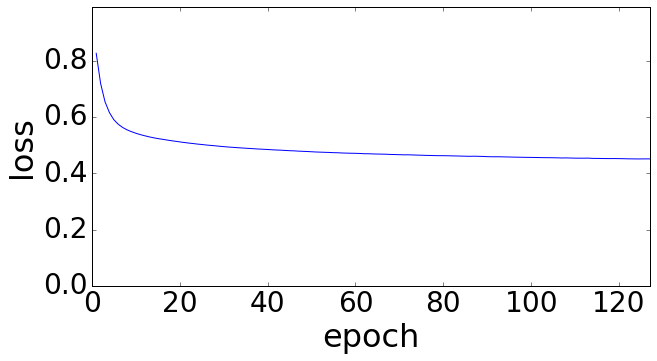

In [12]:
plotLoss(dnn)

### Plot results

In [13]:
def plotDistribution(ada, X_test, y_test, ftsize=FONTSIZE, fgsize=(12,6)):
    
    # predict class "probabilities"
    p = ada.predict_proba(X_test)
    
    # separate probabilities into those for bad and good wines
    bad  = map(lambda x: x[0][-1], filter(lambda x: x[-1], zip(p, y_test < 1)))
    good = map(lambda x: x[0][-1], filter(lambda x: x[-1], zip(p, y_test > 0))) 
    
    # set size of figure
    somerange=(0, 1)
    nbins =40
    plt.figure(figsize=fgsize)
    plt.hist(bad,
             bins=nbins, 
             color=(1, 0, 0),
             alpha=0.3,         # opacity
             range=somerange, 
             normed=True,       # normalize histogram
             label='bad wine')
    pl.legend(fontsize='small') # show legend using specified "label"
    
    plt.xlabel(r'DNN score', fontsize=ftsize)
    
    plt.hist(good,
             bins=nbins, 
             color=(0,1,0),
             alpha=0.3,
             range=somerange, 
             normed=True, 
             label='good wine')
    pl.legend(fontsize='small') # show legend using specified "label"
    
    plt.savefig("01_dnn_distribution.png")
    plt.show()

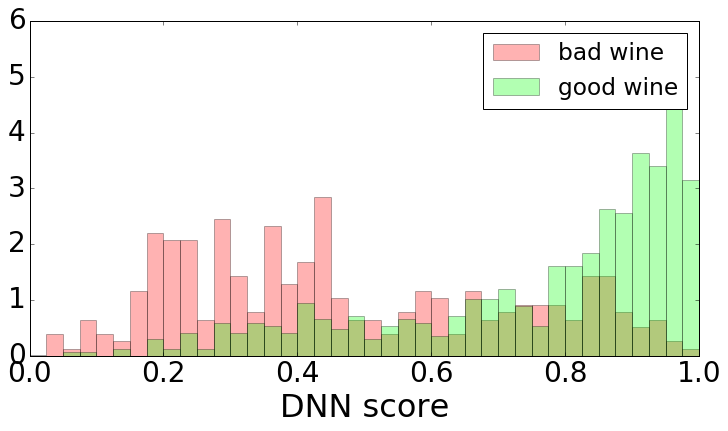

In [14]:
plotDistribution(dnn, X_test, y_test)